This notebook demos how I download Sentinel-2 data for a region of interest using the Sentinel API, then proceeding to mask out + save the raster for the regions of interest. 

It is based on the following excellent resources:

- https://sentinelsat.readthedocs.io/en/master/api_overview.html
- https://towardsdatascience.com/satellite-imagery-access-and-analysis-in-python-jupyter-notebooks-387971ece84b


In [2]:
# start by loading imports + credentials
from sentinelsat import SentinelAPI, make_path_filter # for downloading data
import geopandas as gpd # for reading shapefiles
import folium  # library to create interactive maps
from shapely.geometry import MultiPolygon, Polygon
import os 
import rasterio as rio
from rasterio.mask import mask
import zipfile
import rasterio
import json
import shutil
import cv2
import numpy as np
from tqdm import tqdm
# read credentials.json
with open('credentials.json') as f:
    credentials = json.load(f)

user = credentials['SENTINEL_USER']
password = credentials['SENTINEL_PASSWORD']
api = SentinelAPI(user, password, 'https://scihub.copernicus.eu/dhus')
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# load the shapefile for the region I want to view. (Created using geojson.io)
# in this case, I traced the outline of the NYC area.

nyc_geo = gpd.read_file('data/layers/POLYGON.shp')

In [4]:
# Use folium to visualize the geojson.
m = folium.Map([40.730610, -73.935242], zoom_start=10) 

folium.GeoJson(nyc_geo).add_to(m)
# visualize the map
m

In [5]:
# query sentinel api for all available images of this region over the past ~ 2 years.
# as part of the query, we can also specify things like what instrument, level, and cloud cover fit our preferences.
footprint = None
for i in nyc_geo['geometry']:
    footprint = i

    products = api.query(footprint,
                     date = ('20200101', '20220905'),
                     platformname = 'Sentinel-2',
                     processinglevel = 'Level-2A',
                     cloudcoverpercentage = (0,10) 
                    )
    
products_gdf = api.to_geodataframe(products)
products_gdf['is_online'] = [api.is_online(product_id) for product_id in products_gdf.index]
products_gdf = products_gdf[products_gdf['is_online']]
products_gdf.sort_values('generationdate',ascending=True,inplace=True)
products_gdf.shape    

(36, 42)

In [ ]:
def get_bands(imagery_folders):
    """
    Helper function I created to extract out the three RGB bands that comes from a Sentinel-2 artifact once downloaded.
    
    Given the imagery folder, return 3 arrays produced using rasterio, for each band.
    """

    l2a_folder = os.listdir(f'{imagery_folders}/GRANULE')[0]
    r10_path = f"{imagery_folders}/GRANULE/{l2a_folder}/IMG_DATA/R10m"
    for band in os.listdir(r10_path):
        # extract bands 2,3, and 4 from r10:
        if 'B02' in band:
            b2 = rio.open(f"{r10_path}/{band}")
        elif 'B03' in band:
            b3 = rio.open(f"{r10_path}/{band}")
        elif 'B04' in band:
            b4 = rio.open(f"{r10_path}/{band}")

    return b2, b3, b4

In [ ]:
# Main loop.

# Iterates through the available artifacts, attempts to download and unzip, extract bands, and then save the masked version of the image 
# to a .tiff file (which is much smaller than the original image) for future use. Once completed, deletes the remaining files from 
# the downloaded artifact to preserve memory.

for index in tqdm(products_gdf.index):
        try:
                artifact = api.download(index)
        except Exception as e:
                print(e)
                continue

        # unzip and remove compressed
        try:
                with zipfile.ZipFile(artifact['path']) as z:
                z.extractall()
                print("Extracted all")
                os.remove(artifact['path'])
        except:
                print("Invalid file")    
                continue

        img_dir = artifact['path'].replace('.zip','.SAFE')
                

        # save raster for earlier image, delete un-used files.
        b2, b3, b4 = get_bands(img_dir)


        with rio.open('RGB.tiff','w',driver='Gtiff', width=b4.width, height=b4.height, 
                count=3,crs=b4.crs,transform=b4.transform, dtype=b4.dtypes[0]) as rgb:
                rgb.write(b2.read(1),1) 
                rgb.write(b3.read(1),2) 
                rgb.write(b4.read(1),3) 
                rgb.close()

        with rio.open("RGB.tiff") as src:
                out_meta = src.meta.copy()
                nyc_geo_projected = nyc_geo.to_crs(out_meta['crs'].data)
                out_image, out_transform = mask(src, nyc_geo_projected.geometry,crop=True) 
                out_meta = src.meta.copy()
                out_meta.update({"driver": "GTiff",
                                "height": out_image.shape[1],
                                "width": out_image.shape[2],
                                "transform": out_transform})

        with rasterio.open(f"{artifact['title']}.tiff", "w", **out_meta) as dest:
                dest.write(out_image)


        os.remove("RGB.tiff")
        shutil.rmtree(img_dir)



# Quick Preview of Images

In [6]:
raster = rio.open('data/S2A_MSIL2A_20220226T154221_N0400_R011_T18TWL_20220226T204651.tiff').read()

In [7]:
raster_mean = raster.mean(axis=0)



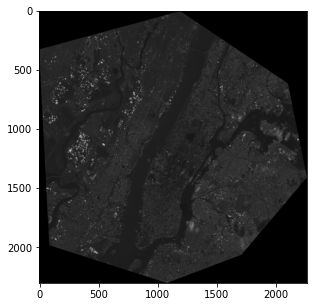

In [8]:
plt.figure(figsize=(5,5))
plt.imshow(raster_mean,cmap='gray')

And that's all it really takes to get your hands on satellite imagery! Next I'll be analyzing the distribution of different land cover types over time for these images using a custom ML model.